# Fake News Detection with LSTM Neural Networks


## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Deep learning libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Create output directory for visualizations and models
if not os.path.exists('visualizations'):
    os.makedirs('visualizations')
if not os.path.exists('models'):
    os.makedirs('models')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. Data Loading and Basic Preprocessing

In [3]:
train_data = pd.read_csv('/content/drive/MyDrive/RealOrFake/Training Data_Testing_data/training_data_lowercase.csv', sep='\t', header=None)

train_data.columns = ['label', 'title']

train_data['label'] = train_data['label'].astype(int)

test_data = pd.read_csv('/content/drive/MyDrive/RealOrFake/Training Data_Testing_data/testing_data_lowercase_nolabels.csv', sep='\t', header=None)
test_data.columns = ['placeholder', 'title']

print(f"Training data shape: {train_data.shape}")
print(f"Testing data shape: {test_data.shape}")
print(f"Label distribution in training data:\n{train_data['label'].value_counts()}")

print(f"\nMissing values in training data:\n{train_data.isnull().sum()}")
print(f"\nMissing values in testing data:\n{test_data.isnull().sum()}")

Training data shape: (34152, 2)
Testing data shape: (9984, 2)
Label distribution in training data:
label
0    17572
1    16580
Name: count, dtype: int64

Missing values in training data:
label    0
title    0
dtype: int64

Missing values in testing data:
placeholder    0
title          0
dtype: int64


In [4]:
def clean_text(text):
    if isinstance(text, str):
        # Remove URLs
        text = re.sub(r'https?://\S+|www\.\S+', '', text)
        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)
        # Remove special characters and punctuation (keep apostrophes for contractions)
        text = re.sub(r'[^\w\s\']', ' ', text)
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        return text.lower()  # Ensure all text is lowercase
    else:
        return ''

train_data['cleaned_title'] = train_data['title'].apply(clean_text)
test_data['cleaned_title'] = test_data['title'].apply(clean_text)

print("\nSample of cleaned titles from training data:")
pd.set_option('display.max_colwidth', 100)
train_data[['title', 'cleaned_title', 'label']].head()

print("\nSample of cleaned titles from testing data:")
test_data[['title', 'cleaned_title']].head()


Sample of cleaned titles from training data:

Sample of cleaned titles from testing data:


,title,cleaned_title
0,copycat muslim terrorist arrested with assault weapons,copycat muslim terrorist arrested with assault weapons
1,wow! chicago protester caught on camera admits violent activity was pre-planned: ‚it‚s not gonna...,wow chicago protester caught on camera admits violent activity was pre planned it s not gonna be...
2,germany's fdp look to fill schaeuble's big shoes,germany's fdp look to fill schaeuble's big shoes
3,mi school sends welcome back packet warning kids against wearing u.s. flag to school,mi school sends welcome back packet warning kids against wearing u s flag to school
4,u.n. seeks 'massive' aid boost amid rohingya 'emergency within an emergency',u n seeks 'massive' aid boost amid rohingya 'emergency within an emergency'


## 4. Prepare Validation Set from Training Data

In [5]:
# Split the training data to create a validation set
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    train_data['cleaned_title'],
    train_data['label'],
    test_size=0.2,
    random_state=42,
    stratify=train_data['label']
)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Testing set size: {len(test_data)}")

Training set size: 27321
Validation set size: 6831
Testing set size: 9984


## 5. Text Tokenization and Sequence Preparation

In [6]:
max_words = 10000
max_sequence_length = 50

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(test_data['cleaned_title'])

# Padding
X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_length, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_sequence_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_sequence_length, padding='post', truncating='post')


vocab_size = len(tokenizer.word_index) + 1  # Add 1 for the 0 index (padding)
print(f"Vocabulary size: {vocab_size}")
print(f"Training padded sequence shape: {X_train_pad.shape}")
print(f"Validation padded sequence shape: {X_val_pad.shape}")
print(f"Testing padded sequence shape: {X_test_pad.shape}")


Vocabulary size: 19155
Training padded sequence shape: (27321, 50)
Validation padded sequence shape: (6831, 50)
Testing padded sequence shape: (9984, 50)


## 6. Build and Train LSTM Model

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

# for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


embedding_dim = 128
vocab_size = 10000  # Example vocab size
max_sequence_length = 200  # Example sequence length

model = Sequential([

    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_shape=(max_sequence_length,)),


    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),

    Bidirectional(LSTM(32)),
    Dropout(0.3),


    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification output
])


model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 200, 128)            │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 200, 128)            │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 200, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,421,089 (5.42 MB)

 Trainable params: 1,421,089 (5.42 MB)

 Non-trainable params: 0 (0.00 B)

# model.fit

In [8]:

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)

batch_size = 64
epochs = 20

history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/20
427/427 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.8558 - loss: 0.2982 - val_accuracy: 0.9715 - val_loss: 0.0773
Epoch 2/20
427/427 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9784 - loss: 0.0613 - val_accuracy: 0.9691 - val_loss: 0.0831
Epoch 3/20
427/427 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9914 - loss: 0.0273 - val_accuracy: 0.9682 - val_loss: 0.1115
Epoch 4/20
427/427 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9943 - loss: 0.0171 - val_accuracy: 0.9606 - val_loss: 0.1556
Epoch 5/20
427/427 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9955 - loss: 0.0137 - val_accuracy: 0.9643 - val_loss: 0.1484
Epoch 6/20
427/427 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9967 - loss: 0.0109 - val_accuracy: 0.9643 - val_loss: 0.1789
Epoch 7/20
427/427 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9979 - loss: 0.0069 - val_accuracy: 0.9659 - val_loss: 0.1898
Epoch 8/20
427/427 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9990 - loss: 0.0040 - val_acc

# Save Model

In [9]:
# Save the trained model in the new format
model.save("lstm_fake_news_model.keras")
print("Model saved as 'lstm_fake_news_model.keras'")


Model saved as 'lstm_fake_news_model.keras'


In [10]:
from tensorflow.keras.models import load_model

# Load the model
best_model = load_model("lstm_fake_news_model.keras")
print("Model loaded successfully!")


Model loaded successfully!


# Predictions

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define tokenizer with the same parameters as before
max_words = 10000  # Must match original training config
max_sequence_length = 50  # Must match original training config

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)  # Refit using training data


In [12]:
# Convert test text to sequences
X_test_seq = tokenizer.texts_to_sequences(test_data['title'])

# Pad sequences (must match training padding settings)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_sequence_length, padding='post', truncating='post')

print(f"Test data padded shape: {X_test_pad.shape}")


Test data padded shape: (9984, 50)


In [13]:
from tensorflow.keras.models import load_model

# Load the saved LSTM model
best_model = load_model("lstm_fake_news_model.keras")

# Generate predictions
print("\nGenerating predictions on test data...")
test_pred_prob = best_model.predict(X_test_pad)

# Convert probabilities to binary labels (0 = Fake, 1 = Real)
test_predictions = (test_pred_prob > 0.5).astype(int).flatten()



Generating predictions on test data...
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


In [14]:
import pandas as pd

# Create DataFrame for predictions
predictions_df = pd.DataFrame({
    'id': range(len(test_data)),  # Assign an ID
    'title': test_data['title'],  # Include original text
    'predicted_label': test_predictions  # 1 = Real, 0 = Fake
})

# Save predictions to CSV
predictions_df.to_csv('lstm_predictions.csv', index=False)
print("\nPredictions saved to 'lstm_predictions.csv'")



Predictions saved to 'lstm_predictions.csv'


In [15]:
import pandas as pd

# Load predictions CSV
predictions_df = pd.read_csv("lstm_predictions.csv")

# Check a few rows
print(predictions_df.head())


   id  \
0   0   
1   1   
2   2   
3   3   
4   4   

                                                                                                 title  \
0                                               copycat muslim terrorist arrested with assault weapons   
1  wow! chicago protester caught on camera admits violent activity was pre-planned: ‚it‚s not gonna...   
2                                                     germany's fdp look to fill schaeuble's big shoes   
3                 mi school sends welcome back packet warning kids against wearing u.s. flag to school   
4                         u.n. seeks 'massive' aid boost amid rohingya 'emergency within an emergency'   

   predicted_label  
0                0  
1                0  
2                1  
3                0  
4                1  


predicted_label
1    5283
0    4701
Name: count, dtype: int64


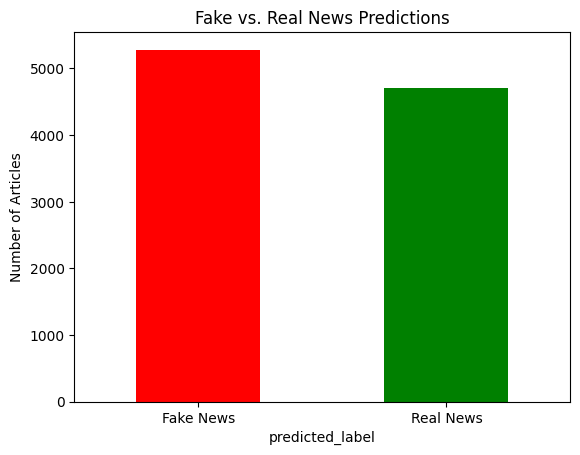

In [16]:
# Count occurrences of each label
print(predictions_df['predicted_label'].value_counts())

# Plot distribution
import matplotlib.pyplot as plt

predictions_df['predicted_label'].value_counts().plot(kind='bar', color=['red', 'green'])
plt.xticks(ticks=[0,1], labels=['Fake News', 'Real News'], rotation=0)
plt.ylabel('Number of Articles')
plt.title('Fake vs. Real News Predictions')
plt.show()

In [17]:
# Check examples predicted as Fake News
fake_news_samples = predictions_df[predictions_df['predicted_label'] == 0]
print(fake_news_samples.head(10))  # Show first 10 fake news predictions

# Check examples predicted as Real News
real_news_samples = predictions_df[predictions_df['predicted_label'] == 1]
print(real_news_samples.head(10))  # Show first 10 real news predictions


    id  \
0    0   
1    1   
3    3   
5    5   
7    7   
12  12   
13  13   
15  15   
16  16   
17  17   

                                                                                                  title  \
0                                                copycat muslim terrorist arrested with assault weapons   
1   wow! chicago protester caught on camera admits violent activity was pre-planned: ‚it‚s not gonna...   
3                  mi school sends welcome back packet warning kids against wearing u.s. flag to school   
5                  did oprah just leave ‚nasty‚ hillary wishing she wouldn‚t have endorsed her? [video]   
7                      flashback: chilling ‚60 minutes‚ interview with george soros nearly 20 years ago   
12                                   finger in every pie: how cia produces our ‚news‚ and entertainment   
13  how malia obama‚s pot smoking friend is connected to her father‚and why this thug with brutal cr...   
15  media ignores post on faceboo